In [ ]:
import torch
from torch import nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary
print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1.12.0+cu113


In [ ]:
class resblock(nn.Module):
    def __init__(self, in_planes, out_planes, downsample):
        super().__init__()
        if downsample: #if the number of channels changes in the residual block(in_planes != out_planes)
            self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=2, padding=1) #change the number of channels from in_planes 
                        #to out_planes and halving the height and width of each channel using stride of 2.
            self.identity = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=2), #use 1x1 convolution to compensate for the change in number of channels
                nn.BatchNorm2d(out_planes)
            )
        else: #if there is no change in the number of channels(in_planes = out_planes)
            self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1)
            self.identity = nn.Sequential() # pass the input of residual block to output directly

        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_planes)
        self.batch_norm2 = nn.BatchNorm2d(out_planes)

    def forward(self, input):
        identity = self.identity(input)
        input = self.conv1(input)
        input = self.batch_norm1(input)
        input = nn.ReLU()(input)
        input = self.conv2(input)
        input = self.batch_norm2(input)
        #input = nn.ReLU()(input)
        input = input + identity
        output = nn.ReLU()(input)
        return output



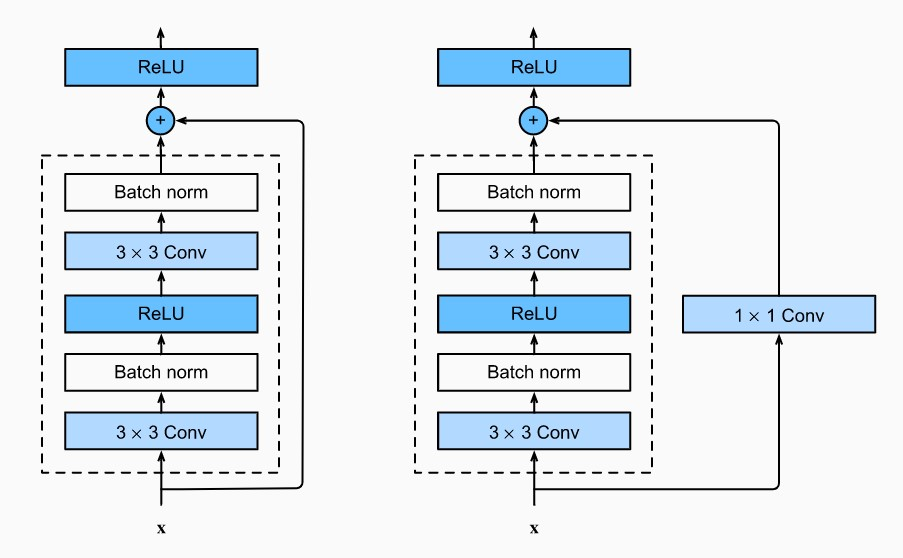

In [ ]:
class resnet(nn.Module):
    def __init__(self, in_planes, resblock, outputs):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_planes, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer4 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )
        self.layer5 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.avg_pooling = nn.AdaptiveAvgPool2d(1)
        self.fully_connected = nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.layer5(input)
        input = self.avg_pooling(input)
        input = input.view(input.size(0),-1)
        input = self.fully_connected(input)
        return input



model = resnet(3, resblock, outputs=10)
model.to(device)

resnet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): resblock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (identity): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): resblock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (identity): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm1): BatchNorm2d(

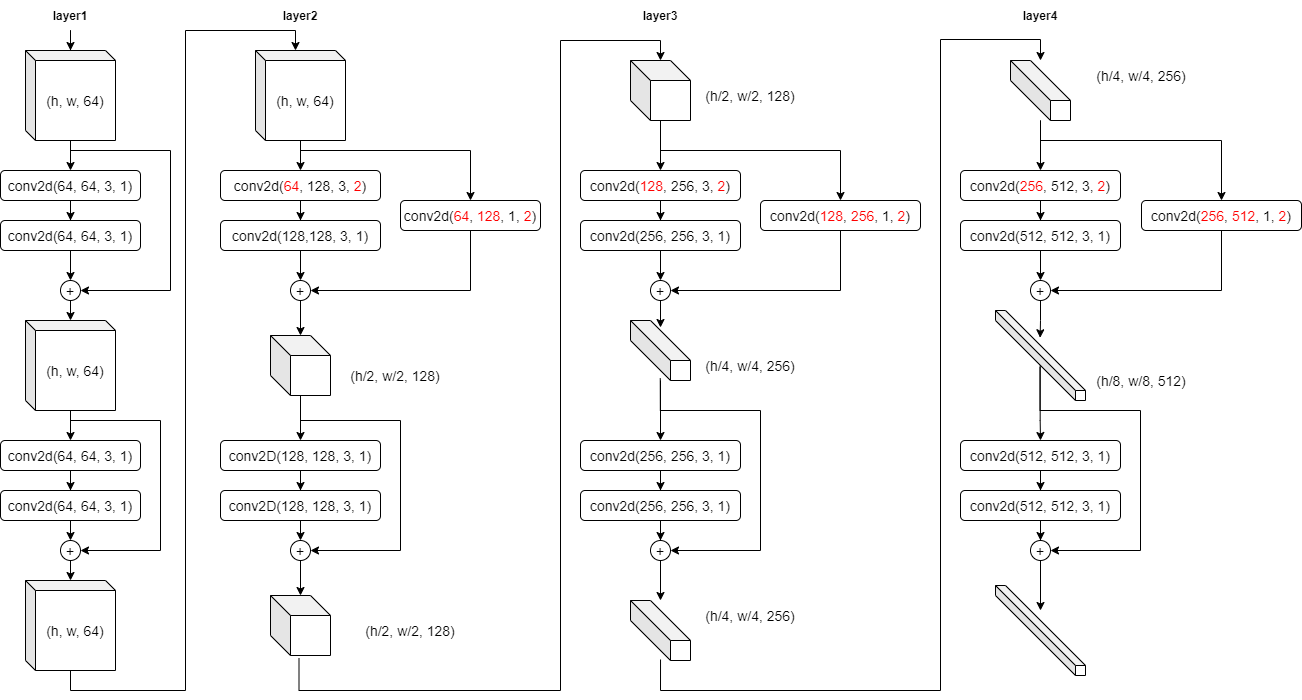

In [ ]:
num_epochs = 100
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)


Files already downloaded and verified


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/100], Step [100/500] Loss: 1.7253
Epoch [1/100], Step [200/500] Loss: 1.4087
Epoch [1/100], Step [300/500] Loss: 1.5809
Epoch [1/100], Step [400/500] Loss: 1.2815
Epoch [1/100], Step [500/500] Loss: 1.2270
Epoch [2/100], Step [100/500] Loss: 1.2789
Epoch [2/100], Step [200/500] Loss: 1.1976
Epoch [2/100], Step [300/500] Loss: 0.9639
Epoch [2/100], Step [400/500] Loss: 1.2245
Epoch [2/100], Step [500/500] Loss: 1.3566
Epoch [3/100], Step [100/500] Loss: 1.0853
Epoch [3/100], Step [200/500] Loss: 1.2297
Epoch [3/100], Step [300/500] Loss: 1.0415
Epoch [3/100], Step [400/500] Loss: 0.8569
Epoch [3/100], Step [500/500] Loss: 1.1260
Epoch [4/100], Step [100/500] Loss: 1.2270
Epoch [4/100], Step [200/500] Loss: 0.9170
Epoch [4/100], Step [300/500] Loss: 0.9774
Epoch [4/100], Step [400/500] Loss: 0.9043
Epoch [4/100], Step [500/500] Loss: 1.0444
Epoch [5/100], Step [100/500] Loss: 0.9200
Epoch [5/100], Step [200/500] Loss: 0.9874
Epoch [5/100], Step [300/500] Loss: 0.9517
Epoch [5/10

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Accuracy of the model on the test images: 85.16 %
